In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sc
import sklearn
import sklearn.feature_extraction
import keras
import gensim.downloader as api

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelBinarizer

from keras import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Embedding

from collections import Counter
from time import time

from StatModel import BayesModel


Using TensorFlow backend.


## Settings

In [3]:
#Data used for train, validation and test
data_path = r"Data/amazon-fine-food-reviews/Reviews.csv"

#Used to check if the model can generalize to a diffrent context
alt_data_path = r"Data/steam_reviews.csv"

model_path = r"Models/"

In [4]:
# Split of the original dataset
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

#Further size reduction to fit in memory and to run the scriptin reasonable time
max_size = 30000
random = 42

In [5]:
# Ignore words with freq <= freq_cutoff
# From frequ distribution
# (not used)
freq_cutoff = 10

# Cut reviews larger than seq_len -> do not fin in memory :(
#-> take first seq_len tokens
#(used)
seq_len = 500

In [6]:
epochs = 2
class_size = 5

## Load Data

In [7]:
data = pd.read_csv(data_path)
#Missing data -> empty string
data["Summary"].fillna("", inplace=True)
data["Text"].fillna("", inplace=True)

## Data Exploration

In [9]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [10]:
#Score is unbalanced
#More than 50% has 5 starts
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


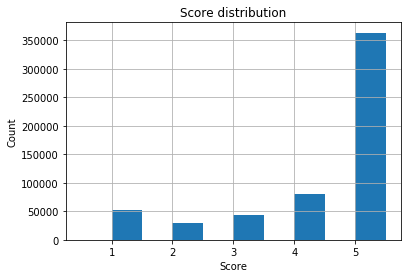

[52268, 29769, 42640, 80655, 363122]

In [7]:
#Label distribution
classes = plt.hist(data["Score"], [0.5*i for i in range(1, 12)])
plt.title("Score distribution")
plt.ylabel("Count")
plt.xlabel("Score")
plt.grid(True)
plt.show()

classes = classes[0]
classes = [int(classes[i]) for i in range(len(classes)) if i%2!=0]
classes

In [10]:
#Tokenizer to count types and tokens
t = Tokenizer()

t.fit_on_texts(data["Text"])
t.fit_on_texts(data["Summary"])

In [11]:
#Types count
types = len(t.word_counts)
#Tokens count
tokens = sum(t.word_counts.values())
print("Types:", types)
print("Tokens:",tokens)
print("Types/Tokens:", types/tokens)

top50 = Counter(t.word_counts).most_common(50)
for i,w in enumerate(top50):
    print(i+1,":", w[1], "\t-", w[0])
    
#In the most common words
#-Common words in English (the, I, and, ...)
#-Preferences (like, good, great, ...)
#-Food bias (database on revies about food)

Types: 139510
Tokens: 48795748
Types/Tokens: 0.0028590605886398136
1 : 1928057 	- the
2 : 1529631 	- i
3 : 1325111 	- and
4 : 1276799 	- a
5 : 1036737 	- to
6 : 960720 	- it
7 : 822664 	- of
8 : 753208 	- is
9 : 699261 	- this
10 : 647090 	- br
11 : 593065 	- for
12 : 562221 	- in
13 : 493082 	- my
14 : 436769 	- that
15 : 401648 	- but
16 : 368806 	- not
17 : 363328 	- with
18 : 350294 	- have
19 : 344135 	- you
20 : 326695 	- are
21 : 319108 	- was
22 : 292600 	- they
23 : 289587 	- as
24 : 280536 	- on
25 : 269597 	- like
26 : 265298 	- so
27 : 252448 	- good
28 : 247304 	- these
29 : 240259 	- great
30 : 218176 	- them
31 : 193875 	- be
32 : 191103 	- coffee
33 : 190605 	- taste
34 : 187410 	- product
35 : 185910 	- at
36 : 184839 	- or
37 : 183578 	- very
38 : 181537 	- one
39 : 180055 	- just
40 : 174561 	- if
41 : 165204 	- all
42 : 161549 	- flavor
43 : 159491 	- tea
44 : 155033 	- love
45 : 150374 	- from
46 : 144075 	- it's
47 : 141572 	- food
48 : 140082 	- more
49 : 139753 

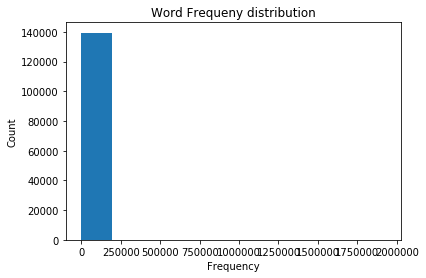

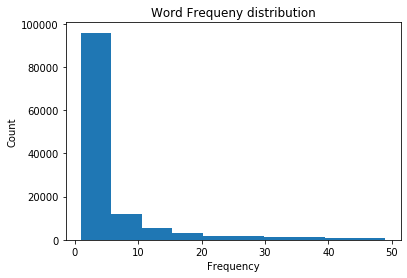

In [12]:
#Token frequency distribution

plt.hist(t.word_counts.values())
plt.ylabel("Count")
plt.xlabel("Frequency")
plt.title("Word Frequeny distribution")
plt.show()

plt.hist([i for i in t.word_counts.values() if i < 50])
plt.ylabel("Count")
plt.xlabel("Frequency")
plt.title("Word Frequeny distribution")
plt.show()
#Most of the words are not common

In [13]:
def count_per_score(score, top = 20):
    #Select score and do the same experiment of before
    t = Tokenizer()
    t.fit_on_texts(data[data["Score"] == score]["Text"])
    t.fit_on_texts(data[data["Score"] == score]["Summary"])
    topn = Counter(t.word_counts).most_common(top)
    print("Most common words with score:", score)
    for i,w in enumerate(topn):
        print(i+1,":", w[1], "\t-", w[0])

for i in range(1, 6):
    count_per_score(i) 

#The really most common words are similar for every score.
#"But" is common in all the group, although it could mean somothing negative
#"Not" is common in all groups except for score=5, so it doesn't (directly) help to discriminate the score
#"Good" is common for score=4 and "Great" for score=5. Both of them have a positive meaning and the 
    #score reflect they grade.


Most common words with score: 1
1 : 205781 	- the
2 : 164351 	- i
3 : 119505 	- and
4 : 104714 	- a
5 : 104347 	- to
6 : 94893 	- it
7 : 85205 	- of
8 : 77128 	- this
9 : 65809 	- br
10 : 65436 	- is
11 : 55941 	- not
12 : 55386 	- in
13 : 50531 	- was
14 : 48135 	- that
15 : 47911 	- for
16 : 41156 	- my
17 : 37702 	- but
18 : 32478 	- have
19 : 32303 	- they
20 : 31094 	- with
Most common words with score: 2
1 : 127372 	- the
2 : 98684 	- i
3 : 67901 	- a
4 : 67217 	- and
5 : 60934 	- to
6 : 59581 	- it
7 : 52235 	- of
8 : 41349 	- this
9 : 38797 	- br
10 : 38656 	- is
11 : 36855 	- not
12 : 31366 	- in
13 : 31196 	- but
14 : 30446 	- for
15 : 28484 	- that
16 : 27369 	- was
17 : 23643 	- my
18 : 20228 	- like
19 : 19574 	- with
20 : 18508 	- have
Most common words with score: 3
1 : 191603 	- the
2 : 139443 	- i
3 : 115450 	- a
4 : 96777 	- and
5 : 93203 	- to
6 : 90483 	- it
7 : 78320 	- of
8 : 67250 	- br
9 : 65140 	- is
10 : 56575 	- but
11 : 56405 	- this
12 : 51373 	- not
13 : 5

In [14]:
#Length of each review
len_text = [len(i) for i in t.texts_to_sequences_generator(data["Text"])]
len_sum = [len(i) for i in t.texts_to_sequences_generator(data["Summary"])]

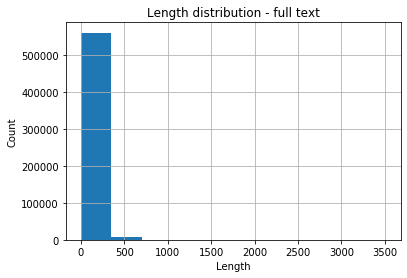

Mean: 81.71757257403414
Std: 81.65936210244709
Meadian: 57.0
Max: 3507
Min: 3


In [15]:
#Length distribution
plt.hist(len_text)
plt.title("Length distribution - full text")
plt.ylabel("Count")
plt.xlabel("Length")
plt.grid(True)
plt.show()
print("Mean:", np.mean(len_text))
print("Std:", np.std(len_text))
print("Meadian:", np.median(len_text))
print("Max:", max(len_text))
print("Min:", min(len_text))

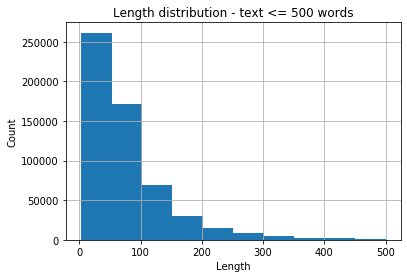

Mean: 78.62273128314116
Std: 67.25715603201122
Meadian: 57.0
Max: 500
Min: 3


In [16]:
len_text_500 = [i for i in len_text if i <= 500]
plt.hist(len_text_500)
plt.title("Length distribution - text <= 500 words")
plt.ylabel("Count")
plt.xlabel("Length")
plt.grid(True)
plt.show()
print("Mean:", np.mean(len_text_500))
print("Std:", np.std(len_text_500))
print("Meadian:", np.median(len_text_500))
print("Max:", max(len_text_500))
print("Min:", min(len_text_500))

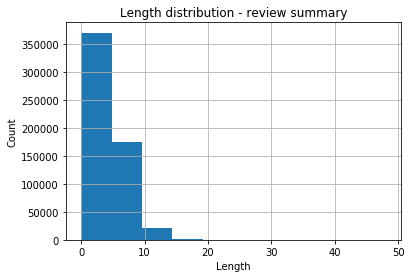

Mean: 4.121823401717641
Std: 2.598148019387071
Meadian: 4.0
Max: 48
Min: 0


In [17]:
plt.hist(len_sum)
plt.title("Length distribution - review summary")
plt.ylabel("Count")
plt.xlabel("Length")
plt.grid(True)
plt.show()
print("Mean:", np.mean(len_sum))
print("Std:", np.std(len_sum))
print("Meadian:", np.median(len_sum))
print("Max:", max(len_sum))
print("Min:", min(len_sum))

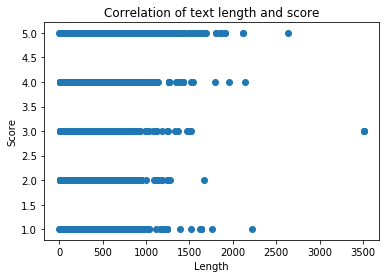

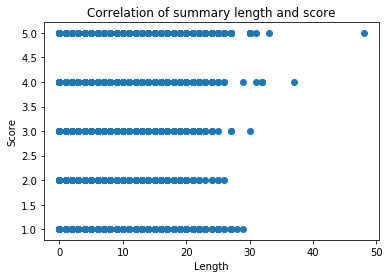

Correlation score and text length: -0.07652517545625775
Correlation score and summary length: -0.07547192835558765


In [18]:
#Correlation between score and length
plt.scatter(len_text, data["Score"])
plt.ylabel("Score")
plt.xlabel("Length")
plt.title("Correlation of text length and score")
plt.show()

plt.scatter(len_sum, data["Score"])
plt.ylabel("Score")
plt.xlabel("Length")
plt.title("Correlation of summary length and score")
plt.show()
plt.show()

print("Correlation score and text length:", np.corrcoef(len_text, data["Score"])[1,0])
print("Correlation score and summary length:", np.corrcoef(len_sum, data["Score"])[1,0])
#Low correlation for both
#Both shifted to the left

## Split Data

In [8]:
#Stratified split
def train_val_test_split(X, y, ratio = [train_ratio, val_ratio, test_ratio], r = random):
    """
    X: features set
    y: label vector
    ratio: proportion of each set, [train, validation, test], sum up to 1
    r: random state
    """    
    X_train, X_remain, y_train, y_remain = train_test_split(X, y, train_size=ratio[0], random_state = r)
    X_val, X_test, y_val, y_test = train_test_split(X_remain, y_remain, train_size=ratio[1] / (1 - ratio[0]), random_state = r)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [9]:
#Discard other columns
reviews = pd.DataFrame(data[["Summary", "Text", "Score"]])
reviews[["Summary", "Text"]] = reviews[["Summary", "Text"]].astype(str)
reviews["Score"] = reviews["Score"].astype(float)
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(reviews[["Summary", "Text"]], reviews["Score"])

#Text
t_train = X_train["Text"]
t_val = X_val["Text"]
t_test = X_test["Text"]

#Summary
s_train = X_train["Summary"]
s_val = X_val["Summary"]
s_test = X_test["Summary"]

#To get both
def join_set(x1, x2, y1, y2 = None):
    if y2 is None:
        y2 = y1
    return x1.append(x2, True), y1.append(y2, True)

## Preprocessing

In [17]:
#Not used
#Try to remove uncommon words to see if the length of the reviews of reduced -> didn't work
voc_size = 0
for i in t.word_counts.values():
    if i > freq_cutoff:
        voc_size += 1
t.num_words = voc_size
print("Vocabulary size (after cutoff):", voc_size)
print("Original size:", types)
print("Frequency cutoff:", freq_cutoff)

NameError: name 't' is not defined

In [ ]:
max_review_size = 0
for i in t.texts_to_sequences_generator(t_train):
    if max_review_size < len(pad_sequences([i])[0]):
        max_review_size = len(pad_sequences([i])[0])
print("Maximum sequence size (after cutoff):", max_review_size)
#Even the frequency cutoff cannot reduce the size

In [10]:
#Clean some space
if "t" in globals():
    del t
if "data" in globals():
    del data
if "reviews" in globals():
    del reviews

In [11]:
#From the most common words in the data exploration part
#Keep some stop words -> ex. not, but, ...
stop_words = [i for i in sklearn.feature_extraction.text.ENGLISH_STOP_WORDS]
to_be_removed = ["almost", "although", "but", "can", "cannot", "could", "couldnt","ever", "every", "few", "full", "further", "has", "hasnt","have","less","many", "more", "mostly","much","never", "no", "none","not","only","some","though", "top","very"]
stop_words = [i for i in stop_words if i not in to_be_removed]

In [12]:
embedding = api.load("glove-wiki-gigaword-50")

In [13]:
print("Embedding vocabulary size:", len(embedding.vocab))
print("Embedding size:", embedding.vector_size)

Embedding vocabulary size: 400000
Embedding size: 50


In [14]:
#Tokenized based on the embedding
tk = Tokenizer(len(embedding.vocab))
tk.word_index = {w: v.index for w, v in embedding.vocab.items() if w not in stop_words}

In [15]:
#Limit the size of the datasets
def reduce(x1, x2, y, max_size=max_size, r = random):
    """
    x1: reviews
    x2: summaries
    y: labels
    max_size: limit the size of the dataset to max_size
    r: random state
    
    Reduce the size of the dataset. The exceeding part is discarded
    
    x1, y2 and y must be of the same size
    If max_size is larger than x1,x2,y the original set is returned
    """
    if len(x1) != len(x2):
        raise ValueError("The two set must have the same size")
    if max_size < len(x1):
        tmp = pd.DataFrame()
        tmp["x1"] = x1
        tmp["x2"] = x2
        tmp, _, y, _ = train_test_split(tmp, y, train_size = max_size, random_state=random, stratify=y)
        x1 = tmp["x1"]
        x2 = tmp["x2"]
    return x1, x2, y

def make_label(y):
    """From numbers to one.hot vector"""
    encoder = LabelBinarizer()
    encoder.classes_ = [1,2,3,4,5]
    return encoder.transform(y)    

def get_sequences(tk, x, y, max_len = None):        
    """Return a list of sequence of the same length
    tk: keras tokenizer
    x: data
    y: label (not used)
    max_len: limits the sequence to the first max_len tokens if not none
    """
    return pad_sequences(tk.texts_to_sequences(x), max_len)

The remaining part of the data preprocessing is only for the LSTM models.
The BayesModel has its own internal representation and it can handle strings or larger sets.

In [16]:
t_train, s_train, y_train = reduce(t_train, s_train, y_train)
t_val, s_val, y_val = reduce(t_val, s_val, y_val)
t_test, s_test, y_test = reduce(t_test, s_test, y_test)

In [17]:
print("Reduced train size:", len(t_train))
print("Reduced validation size:", len(t_val))
print("Reduced test size:", len(t_test))

Reduced train size: 30000
Reduced validation size: 30000
Reduced test size: 30000


In [18]:
y_train = make_label(y_train)
y_val = make_label(y_val)
y_test = make_label(y_test)

In [19]:
s_train = get_sequences(tk, s_train, seq_len)
s_val = get_sequences(tk, s_val, seq_len)
s_test = get_sequences(tk, s_test, seq_len)

print("Summary train shape:", s_train.shape)

Summary train shape: (30000, 20)


In [20]:
t_train = get_sequences(tk, t_train, seq_len)
t_val = get_sequences(tk, t_val, seq_len)
t_test = get_sequences(tk, t_test, seq_len)
print("Review train shape:", t_train.shape)

Review train shape: (30000, 830)


## Models

### Dummy Classifiers

Since the examples with score equals to 5 are the majority, it is easy to obtain a model with an high accuracy. Therefore the models I want to obtain must perform better than those kinds of models.

In [33]:
dummy_text_clf = DummyClassifier(strategy="prior", random_state = random)
dummy_summary_clf = DummyClassifier(strategy="prior", random_state = random)
dummy_both_clf = DummyClassifier(strategy="prior", random_state = random)

print("Training dummy classifiers...")
t_ = time()

dummy_text_clf.fit(t_train, y_train)
dummy_summary_clf.fit(s_train, y_train)
dummy_both_clf.fit(t_train.append(s_train, True), np.concatenate((y_train, y_train), axis=0))

print("--Done: {:.2f}".format(time()-t_))

Training dummy classifiers...
--Done: 0.01


In [34]:
print("Dummy classifier on text")
y_pred = dummy_text_clf.predict(t_test)
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize="all"))
print()
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print()

print("Dummy classifier on summary")
y_pred = dummy_summary_clf.predict(s_test)
print(confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1), normalize="all"))
print()
print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1)))
print()

print("Dummy classifier on both\n")
y_pred = dummy_text_clf.predict(t_test.append(s_test,True))
print(confusion_matrix(np.concatenate((y_train, y_train), axis=0).argmax(axis=1), y_pred.argmax(axis=1), normalize="all"))
print()
print(classification_report(np.concatenate((y_train, y_train), axis=0).argmax(axis=1), y_pred.argmax(axis=1)))
print()

#Since the models are trained on the same distribution of labels they all have results
#The base accuracy is 0.44
#This evaluation doesn't take in account how big is the error: 
    #predict 1 while the true value is 5 is worse than predicting 4 while the true value is 5

Dummy classifier on text
[[0.     0.     0.     0.     0.09  ]
 [0.     0.     0.     0.     0.0514]
 [0.     0.     0.     0.     0.0765]
 [0.     0.     0.     0.     0.1431]
 [0.     0.     0.     0.     0.639 ]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       900
           1       0.00      0.00      0.00       514
           2       0.00      0.00      0.00       765
           3       0.00      0.00      0.00      1431
           4       0.64      1.00      0.78      6390

    accuracy                           0.64     10000
   macro avg       0.13      0.20      0.16     10000
weighted avg       0.41      0.64      0.50     10000


Dummy classifier on summary
[[0.     0.     0.     0.     0.09  ]
 [0.     0.     0.     0.     0.0514]
 [0.     0.     0.     0.     0.0765]
 [0.     0.     0.     0.     0.1431]
 [0.     0.     0.     0.     0.639 ]]

              precision    recall  f1-score   support

           0      

/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Bayesian model

Use 3-gram model and alpha-smoothing. The log-probability of a sentence is the sum of the log-probabilities of each n-gram. The total probability is divided by the number of 3-grams to obtain a valid probability. Use text and not embedded vectors.

In [244]:
bm = BayesModel(tk.split, tk.filters, stop_words, [1,2,3,4,5], alpha= 1)
bm.fit(t_train.append(s_train, True), np.concatenate((y_train, y_train), axis=0))

Training:: [||||||||||||||||||||||||||||||||||||||||||||||||||] 100.00% completed


In [245]:
print("Bayes Model on text")
y_pred = bm.predict(t_test)
print(confusion_matrix(y_test, y_pred, normalize="all"))
print()
print(classification_report(y_test, y_pred))
print()

print("Bayes Model on summary")
y_pred = bm.predict(s_test)
print(confusion_matrix(y_test, y_pred, normalize="all"))
print()
print(classification_report(y_test, y_pred))
print()

Bayes Model on text
[[0.         0.         0.         0.03085529 0.05914224]
 [0.         0.         0.         0.0161313  0.03525314]
 [0.         0.         0.         0.02429371 0.05222883]
 [0.         0.         0.         0.04341554 0.09969039]
 [0.         0.         0.         0.18789361 0.45109594]]

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      5116
         2.0       0.00      0.00      0.00      2921
         3.0       0.00      0.00      0.00      4350
         4.0       0.14      0.30      0.19      8135
         5.0       0.65      0.71      0.68     36324

    accuracy                           0.49     56846
   macro avg       0.16      0.20      0.17     56846
weighted avg       0.43      0.49      0.46     56846


Bayes Model on summary


/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[0.         0.         0.         0.00554129 0.08445625]
 [0.         0.         0.         0.00313127 0.04825318]
 [0.         0.         0.         0.00436266 0.07215987]
 [0.         0.         0.         0.00818    0.13492594]
 [0.         0.         0.         0.03724097 0.60174858]]

              precision    recall  f1-score   support

         1.0       0.00      0.00      0.00      5116
         2.0       0.00      0.00      0.00      2921
         3.0       0.00      0.00      0.00      4350
         4.0       0.14      0.06      0.08      8135
         5.0       0.64      0.94      0.76     36324

    accuracy                           0.61     56846
   macro avg       0.16      0.20      0.17     56846
weighted avg       0.43      0.61      0.50     56846




/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [246]:
print(bm.predict_proba(t_train[:5]))
print(bm.predict(t_train[:5]))
print(y_train[:5])
print("It is really bad:", bm.predict(["It is really bad"]))
print("It is disgusting:", bm.predict(["It is disgusting"]))
print("It is perfect:", bm.predict(["It is perfect"]))

[array([0.0999923 , 0.05880221, 0.08836071, 0.15917941, 0.59362217]), array([0.09987429, 0.05891651, 0.08875092, 0.16003034, 0.59138723]), array([0.09958094, 0.05885303, 0.08877404, 0.16014627, 0.58867552]), array([0.0987156 , 0.05856907, 0.08864661, 0.16013605, 0.58183535]), array([0.09890612, 0.0579767 , 0.08681126, 0.1561333 , 0.58825474])]
[5. 5. 5. 5. 5.]
251349    1.0
523262    5.0
224543    5.0
291632    4.0
37385     5.0
Name: Score, dtype: float64
It is really bad: [5.]
It is disgusting: [5.]
It is perfect: [5.]


### Neural Network

I will try different models, based on Lab3
For the summary of the review the sequence is short, so it is quite straightfoward, but for the text there are much longer sequences, so they are cut at 500 tokens

In [21]:
def evaluate(model, x, y):
    metrics = model.evaluate(x, y)
    y_pred = model.predict(x).argmax(axis=1)
    y = y.argmax(axis=1)
    print("Loss:", metrics[0])
    print("Accuracy:", metrics[1])
    print("Others:", metrics[2:])
    print(confusion_matrix(y, y_pred, normalize="all"))
    print()
    print(classification_report(y, y_pred))
    print()
    return metrics, y_pred

def train(model, x, y, val_x, val_y, epochs):
    print("Training...")
    t = time()
    history =model.fit(x, y, validation_data=(val_x, val_y), epochs=epochs, workers = -1, shuffle=True)
    print("--Done:", time()-t,"s")
    return history
    
def save(model, name):
    model.save(model_path + name)
    
def plot_train(history):
    plt.plot(history.history["loss"], label="Loss")
    plt.plot(history.history["val_loss"], label="Val loss")
    plt.title("Loss")
    plt.xlabel("Epoch")    
    plt.legend()
    plt.grid()
    plt.show()
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="Val accuracy")
    plt.plot(history.history["precision_1"], label="Precision")
    plt.plot(history.history["val_precision_1"], label="Val precision")
    plt.plot(history.history["recall_1"], label="Recall")
    plt.plot(history.history["val_recall_1"], label="Val recall")
    plt.xlabel("Epoch")
    plt.legend()
    plt.grid()
    plt.show()

In [38]:
def make_LSTM2Dense(embedding = embedding, load = False, model = ""):
    m = Sequential()    
    #Embedding
    m.add(embedding.get_keras_embedding(True)) 

    m.add(LSTM(128, return_sequences=False))

    m.add(Dense(75, activation='relu'))
    m.add(Dense(25, activation='relu'))
    m.add(Dense(class_size, activation='softmax'))

    #from documentation: metrics is CategoricalAccuray because of the loss function
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    m.summary()
    if load:
        if model == "":
            raise ValueError("Invalid model name")
        m.load_weights(model_path+model)       
    return m

m= make_LSTM2Dense()

Training...


/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30000 samples, validate on 30000 samples
Epoch 1/2
30000/30000 [==============================] - 994s 33ms/step - loss: 0.9515 - accuracy: 0.6643 - precision_1: 0.7555 - recall_1: 0.5710 - val_loss: 0.8387 - val_accuracy: 0.6954 - val_precision_1: 0.8232 - val_recall_1: 0.5645
Epoch 2/2
30000/30000 [==============================] - 884s 29ms/step - loss: 0.7798 - accuracy: 0.7054 - precision_1: 0.8163 - recall_1: 0.6153 - val_loss: 0.7772 - val_accuracy: 0.7137 - val_precision_1: 0.8150 - val_recall_1: 0.6235
--Done: 1878.3025352954865 s


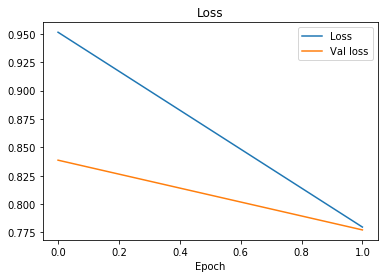

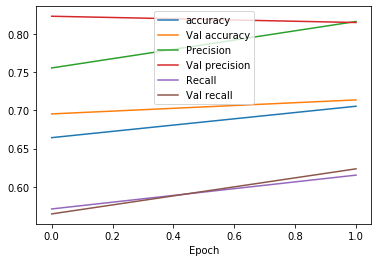

In [40]:
history_LSTM2Dense = train(m, t_train, y_train, t_val, y_val, epochs)
save(m, "LSTM2Dense{}_emb.h5".format(epochs))

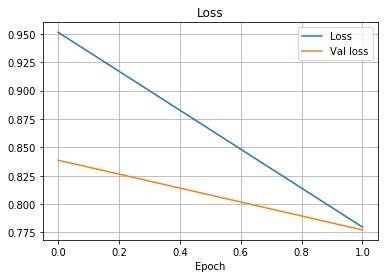

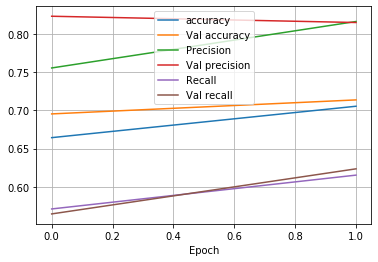

In [42]:
plot_train(history_LSTM2Dense)

In [43]:
evaluate(m, t_test, y_test)
evaluate(m, s_test, y_test)

30000/30000 [==============================] - 151s 5ms/step
Loss: 0.7924926433563232
Accuracy: 0.7040666937828064
Others: [0.8065375089645386, 0.6160333156585693]
[[0.05876667 0.0029     0.00366667 0.00153333 0.02313333]
 [0.01766667 0.00406667 0.0069     0.00426667 0.01846667]
 [0.0101     0.00426667 0.0131     0.01483333 0.03423333]
 [0.00416667 0.00136667 0.0072     0.02556667 0.1048    ]
 [0.0096     0.00096667 0.00396667 0.0219     0.60256667]]

              precision    recall  f1-score   support

           0       0.59      0.65      0.62      2700
           1       0.30      0.08      0.13      1541
           2       0.38      0.17      0.24      2296
           3       0.38      0.18      0.24      4293
           4       0.77      0.94      0.85     19170

    accuracy                           0.70     30000
   macro avg       0.48      0.40      0.41     30000
weighted avg       0.64      0.70      0.66     30000


30000/30000 [==============================] - 7s 239u

([0.9680330053647359,
  0.6717666387557983,
  0.7972701191902161,
  0.4887000024318695],
 array([0, 2, 4, ..., 0, 4, 4]))

In [57]:
def make_LSTMDeep(embedding = embedding, train_emb = True, load = False, model = "", drop = 0.2):    
    m = Sequential()    
    #Embedding
    m.add(embedding.get_keras_embedding(train_emb)) 

    m.add(LSTM(256, return_sequences=False))

    m.add(Dense(100, activation='relu'))
    m.add(keras.layers.Dropout(drop))
    m.add(Dense(50, activation='relu'))
    m.add(keras.layers.Dropout(drop))
    m.add(Dense(50, activation='relu'))
    m.add(keras.layers.Dropout(drop))
    m.add(Dense(25, activation='relu'))
    m.add(keras.layers.Dropout(drop))
    m.add(Dense(class_size, activation='softmax'))

    #from documentation: metrics is CategoricalAccuray because of the loss function
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    m.summary()
    if load:
        if model == "":
            raise ValueError("Invalid model name")
        m.load_weights(model_path+model)
    return m

#m.load_weights(model_path + "LSTMDeep10_emb.h5")

In [ ]:
m= make_LSTMDeep()

Training...


/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30000 samples, validate on 30000 samples
Epoch 1/2
30000/30000 [==============================] - 957s 32ms/step - loss: 1.0246 - accuracy: 0.6534 - precision_1: 0.7584 - recall_1: 0.5066 - val_loss: 0.9233 - val_accuracy: 0.6688 - val_precision_1: 0.8294 - val_recall_1: 0.5242
Epoch 2/2
30000/30000 [==============================] - 884s 29ms/step - loss: 0.8532 - accuracy: 0.6897 - precision_1: 0.8069 - recall_1: 0.5935 - val_loss: 0.8216 - val_accuracy: 0.6951 - val_precision_1: 0.8069 - val_recall_1: 0.6115
--Done: 1841.9989867210388 s


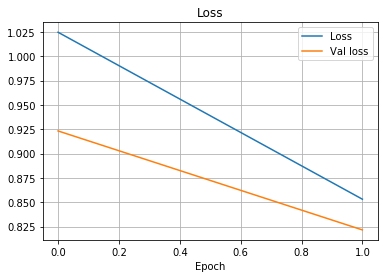

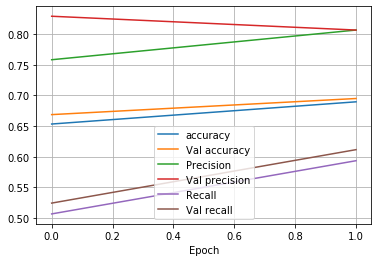

In [23]:
history_LSTMDeep = train(m, t_train, y_train, t_val, y_val, epochs)
save(m, "LSTMDeep_ep{}_emb.h5".format(epochs))
plot_train(history_LSTMDeep)

In [24]:
evaluate(m, t_test, y_test)

30000/30000 [==============================] - 195s 7ms/step
Loss: 0.8295222302436829
Accuracy: 0.6883000135421753
Others: [0.8029410243034363, 0.6042666435241699]
[[7.33333333e-02 0.00000000e+00 5.00000000e-04 0.00000000e+00
  1.61666667e-02]
 [3.29000000e-02 0.00000000e+00 9.66666667e-04 0.00000000e+00
  1.75000000e-02]
 [3.00000000e-02 0.00000000e+00 3.16666667e-03 0.00000000e+00
  4.33666667e-02]
 [1.71333333e-02 0.00000000e+00 1.56666667e-03 0.00000000e+00
  1.24400000e-01]
 [2.56333333e-02 0.00000000e+00 1.56666667e-03 0.00000000e+00
  6.11800000e-01]]

              precision    recall  f1-score   support

           0       0.41      0.81      0.55      2700
           1       0.00      0.00      0.00      1541
           2       0.41      0.04      0.08      2296
           3       0.00      0.00      0.00      4293
           4       0.75      0.96      0.84     19170

    accuracy                           0.69     30000
   macro avg       0.31      0.36      0.29     30000


/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


([0.8295222302436829,
  0.6883000135421753,
  0.8029410243034363,
  0.6042666435241699],
 array([0, 4, 4, ..., 0, 4, 4]))

In [25]:
evaluate(m, s_test, y_test)

30000/30000 [==============================] - 6s 215us/step
Loss: 0.9189442896525065
Accuracy: 0.6708999872207642
Others: [0.7756327390670776, 0.5598000288009644]
[[4.87000000e-02 0.00000000e+00 8.66666667e-04 0.00000000e+00
  4.04333333e-02]
 [1.97666667e-02 0.00000000e+00 1.26666667e-03 0.00000000e+00
  3.03333333e-02]
 [1.88333333e-02 0.00000000e+00 1.86666667e-03 0.00000000e+00
  5.58333333e-02]
 [1.00666667e-02 0.00000000e+00 1.03333333e-03 0.00000000e+00
  1.32000000e-01]
 [1.80666667e-02 0.00000000e+00 6.00000000e-04 0.00000000e+00
  6.20333333e-01]]

              precision    recall  f1-score   support

           0       0.42      0.54      0.47      2700
           1       0.00      0.00      0.00      1541
           2       0.33      0.02      0.05      2296
           3       0.00      0.00      0.00      4293
           4       0.71      0.97      0.82     19170

    accuracy                           0.67     30000
   macro avg       0.29      0.31      0.27     30000


([0.9189442896525065,
  0.6708999872207642,
  0.7756327390670776,
  0.5598000288009644],
 array([0, 4, 4, ..., 0, 4, 4]))

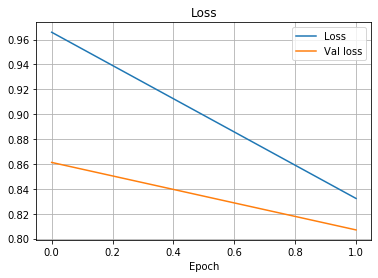

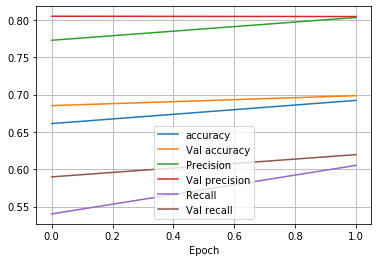

In [34]:
m2 = make_LSTMDeep()
print("Training...")
t = time()
history_deep2 = m2.fit(np.concatenate((t_train, np.pad(s_train, [[0,0],[t_train.shape[1]-s_train.shape[1],0]])), axis=0),
                       np.concatenate((y_train, y_train), axis=0), 
       validation_data=(np.concatenate((t_val, np.pad(s_val, [[0,0],[t_val.shape[1]-s_val.shape[1],0]])), axis=0),
                        np.concatenate((y_val, y_val), axis=0)),
       epochs=epochs, 
       workers = -1,
      shuffle = True)
print("--Done:", time()-t,"s")   
save(m2, "LSTMDeep2ep{}_emb.h5".format(epochs))
    
plot_train(history_deep2)

In [35]:
evaluate(m2, s_test, y_test)
evaluate(m2, t_test, y_test)

30000/30000 [==============================] - 7s 217us/step
Loss: 0.8386892484664917
Accuracy: 0.6845666766166687
Others: [0.7841619253158569, 0.6146000027656555]
[[5.16666667e-02 0.00000000e+00 1.53333333e-03 0.00000000e+00
  3.68000000e-02]
 [2.46666667e-02 0.00000000e+00 2.10000000e-03 0.00000000e+00
  2.46000000e-02]
 [1.85000000e-02 0.00000000e+00 4.40000000e-03 6.66666667e-05
  5.35666667e-02]
 [5.93333333e-03 0.00000000e+00 2.06666667e-03 6.66666667e-05
  1.35033333e-01]
 [9.00000000e-03 0.00000000e+00 1.56666667e-03 0.00000000e+00
  6.28433333e-01]]

              precision    recall  f1-score   support

           0       0.47      0.57      0.52      2700
           1       0.00      0.00      0.00      1541
           2       0.38      0.06      0.10      2296
           3       0.50      0.00      0.00      4293
           4       0.72      0.98      0.83     19170

    accuracy                           0.68     30000
   macro avg       0.41      0.32      0.29     30000


/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


30000/30000 [==============================] - 186s 6ms/step
Loss: 0.7979303022702535
Accuracy: 0.6970666646957397
Others: [0.8105267882347107, 0.6118666529655457]
[[6.24333333e-02 0.00000000e+00 3.86666667e-03 0.00000000e+00
  2.37000000e-02]
 [2.53000000e-02 0.00000000e+00 4.63333333e-03 0.00000000e+00
  2.14333333e-02]
 [1.88666667e-02 0.00000000e+00 7.76666667e-03 3.33333333e-05
  4.98666667e-02]
 [7.20000000e-03 0.00000000e+00 4.86666667e-03 3.33333333e-05
  1.31000000e-01]
 [9.00000000e-03 0.00000000e+00 3.16666667e-03 0.00000000e+00
  6.26833333e-01]]

              precision    recall  f1-score   support

           0       0.51      0.69      0.59      2700
           1       0.00      0.00      0.00      1541
           2       0.32      0.10      0.15      2296
           3       0.50      0.00      0.00      4293
           4       0.74      0.98      0.84     19170

    accuracy                           0.70     30000
   macro avg       0.41      0.36      0.32     30000


([0.7979303022702535,
  0.6970666646957397,
  0.8105267882347107,
  0.6118666529655457],
 array([0, 4, 4, ..., 0, 4, 4]))

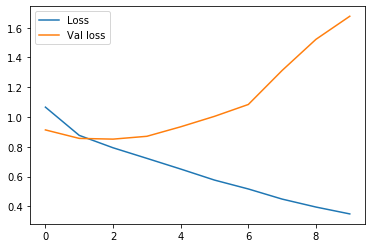

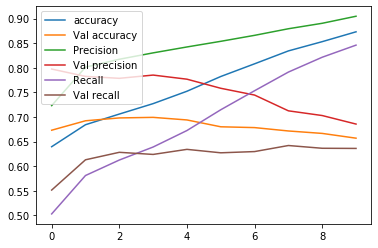

In [256]:
m = make_LSTMDeep(drop = 0.4)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 50)          20000000  
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_5 (Dense)              (None, 100)               25700     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)               

Training...


/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30000 samples, validate on 30000 samples
Epoch 1/5
30000/30000 [==============================] - 905s 30ms/step - loss: 1.0726 - accuracy: 0.6351 - precision_1: 0.7699 - recall_1: 0.4493 - val_loss: 0.9358 - val_accuracy: 0.6488 - val_precision_1: 0.7695 - val_recall_1: 0.5884
Epoch 2/5
30000/30000 [==============================] - 863s 29ms/step - loss: 0.9052 - accuracy: 0.6735 - precision_1: 0.8085 - recall_1: 0.5588 - val_loss: 0.8483 - val_accuracy: 0.6931 - val_precision_1: 0.8013 - val_recall_1: 0.5958
Epoch 3/5
30000/30000 [==============================] - 892s 30ms/step - loss: 0.8192 - accuracy: 0.6945 - precision_1: 0.8155 - recall_1: 0.6028 - val_loss: 0.8477 - val_accuracy: 0.6935 - val_precision_1: 0.8329 - val_recall_1: 0.5802
Epoch 4/5
30000/30000 [==============================] - 1052s 35ms/step - loss: 0.7523 - accuracy: 0.7063 - precision_1: 0.8307 - recall_1: 0.6228 - val_loss: 0.8842 - val_accuracy: 0.6912 - val_precision_1: 0.7846 - val_recall_1: 0.63

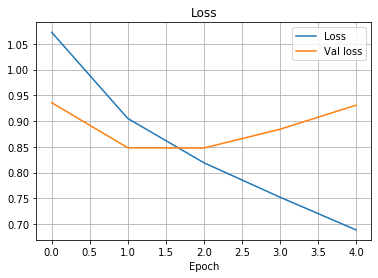

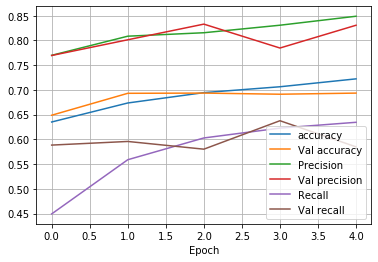

30000/30000 [==============================] - 6s 192us/step
Loss: 1.1573166323979696
Accuracy: 0.630466639995575
Others: [0.7803665399551392, 0.5493000149726868]
[[5.31000000e-02 0.00000000e+00 1.56666667e-02 7.66666667e-04
  2.04666667e-02]
 [2.29000000e-02 0.00000000e+00 1.31000000e-02 5.33333333e-04
  1.48333333e-02]
 [2.22666667e-02 0.00000000e+00 2.05333333e-02 1.73333333e-03
  3.20000000e-02]
 [1.33000000e-02 0.00000000e+00 1.84333333e-02 1.83333333e-03
  1.09533333e-01]
 [4.25000000e-02 0.00000000e+00 3.89333333e-02 2.56666667e-03
  5.55000000e-01]]

              precision    recall  f1-score   support

           0       0.34      0.59      0.44      2700
           1       0.00      0.00      0.00      1541
           2       0.19      0.27      0.22      2296
           3       0.25      0.01      0.02      4293
           4       0.76      0.87      0.81     19170

    accuracy                           0.63     30000
   macro avg       0.31      0.35      0.30     30000
w

/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


30000/30000 [==============================] - 184s 6ms/step
Loss: 0.9522764639854431
Accuracy: 0.6908000111579895
Others: [0.8250237703323364, 0.5780666470527649]
[[0.05856667 0.         0.0158     0.00113333 0.0145    ]
 [0.02116667 0.         0.016      0.00166667 0.01253333]
 [0.01366667 0.         0.02673333 0.0035     0.03263333]
 [0.00496667 0.         0.01896667 0.0043     0.11486667]
 [0.00813333 0.         0.0249     0.00476667 0.6012    ]]

              precision    recall  f1-score   support

           0       0.55      0.65      0.60      2700
           1       0.00      0.00      0.00      1541
           2       0.26      0.35      0.30      2296
           3       0.28      0.03      0.05      4293
           4       0.78      0.94      0.85     19170

    accuracy                           0.69     30000
   macro avg       0.37      0.39      0.36     30000
weighted avg       0.60      0.69      0.63     30000




([0.9522764639854431,
  0.6908000111579895,
  0.8250237703323364,
  0.5780666470527649],
 array([0, 4, 4, ..., 0, 4, 4]))

In [257]:
history_LSTMDeepDrop = train(m, t_train, y_train, t_val, y_val, 5)
save(m, "LSTMDeepDrop{}_emb.h5".format(5))
plot_train(history_LSTMDeepDrop)
evaluate(m, s_test, y_test)
evaluate(m, t_test, y_test)

In [54]:
def make_LSTMEmb(emb_in_size, emb_out_size, load = False, model = "", drop = 0.2):    
    m = Sequential()    
    m.add(Embedding(emb_in_size, emb_out_size))
    m.add(LSTM(256, return_sequences=False))

    m.add(Dense(100, activation='relu'))
    m.add(keras.layers.Dropout(drop))
    m.add(Dense(50, activation='relu'))
    m.add(keras.layers.Dropout(drop))
    m.add(Dense(50, activation='relu'))
    m.add(keras.layers.Dropout(drop))
    m.add(Dense(25, activation='relu'))
    m.add(keras.layers.Dropout(drop))
    m.add(Dense(class_size, activation='softmax'))

    #from documentation: metrics is CategoricalAccuray because of the loss function
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall()])
    m.summary()
    if load:
        if model == "":
            raise ValueError("Invalid model name")
        m.load_weights(model_path+model)
    return m
          
m = make_LSTMEmb(len(tk.word_index)+1000, 20)                

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 20)          8014260   
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               283648    
_________________________________________________________________
dense_6 (Dense)              (None, 100)               25700     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

In [55]:
history_LSTMEmb = train(m, t_train, y_train, t_val, y_val, 5)
save(m, "LSTMEmb{}.h5".format(5))

Training...


/home/gianluca/anaconda3/envs/NLP/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 30000 samples, validate on 30000 samples
Epoch 1/5
30000/30000 [==============================] - 2130s 71ms/step - loss: 0.9953 - accuracy: 0.6480 - precision_2: 0.7735 - recall_2: 0.5259 - val_loss: 0.8827 - val_accuracy: 0.6840 - val_precision_2: 0.7801 - val_recall_2: 0.5988
Epoch 2/5
30000/30000 [==============================] - 2319s 77ms/step - loss: 0.8277 - accuracy: 0.6925 - precision_2: 0.8117 - recall_2: 0.6001 - val_loss: 0.8778 - val_accuracy: 0.6866 - val_precision_2: 0.7929 - val_recall_2: 0.5974
Epoch 3/5
30000/30000 [==============================] - 2268s 76ms/step - loss: 0.7411 - accuracy: 0.7088 - precision_2: 0.8342 - recall_2: 0.6244 - val_loss: 0.8780 - val_accuracy: 0.6904 - val_precision_2: 0.8005 - val_recall_2: 0.6088
Epoch 4/5
30000/30000 [==============================] - 2228s 74ms/step - loss: 0.6632 - accuracy: 0.7363 - precision_2: 0.8595 - recall_2: 0.6398 - val_loss: 0.9196 - val_accuracy: 0.6862 - val_precision_2: 0.7866 - val_recall_2: 0

In [56]:
#m = make_LSTMEmb(len(tk.word_index), 20, load = True, model = "LSTMEmb5.h5")                
evaluate(m, t_test, y_test)
evaluate(m, s_test, y_test)

30000/30000 [==============================] - 633s 21ms/step
Loss: 1.0865196674982707
Accuracy: 0.6736000180244446
Others: [0.7955529689788818, 0.5879666805267334]
[[5.27333333e-02 2.00000000e-04 1.62000000e-02 4.00000000e-03
  1.68666667e-02]
 [1.73666667e-02 2.33333333e-04 1.66000000e-02 4.60000000e-03
  1.25666667e-02]
 [1.06666667e-02 3.00000000e-04 2.75333333e-02 1.10000000e-02
  2.70333333e-02]
 [5.23333333e-03 2.00000000e-04 1.95666667e-02 2.20666667e-02
  9.60333333e-02]
 [1.09000000e-02 6.66666667e-05 2.58666667e-02 3.11333333e-02
  5.71033333e-01]]

              precision    recall  f1-score   support

           0       0.54      0.59      0.56      2700
           1       0.23      0.00      0.01      1541
           2       0.26      0.36      0.30      2296
           3       0.30      0.15      0.20      4293
           4       0.79      0.89      0.84     19170

    accuracy                           0.67     30000
   macro avg       0.43      0.40      0.38     30000

([1.5893288244247437,
  0.33196666836738586,
  0.6446167826652527,
  0.188400000333786],
 array([3, 3, 0, ..., 0, 4, 2]))

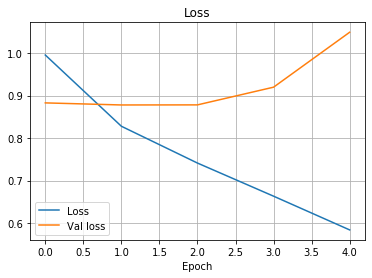

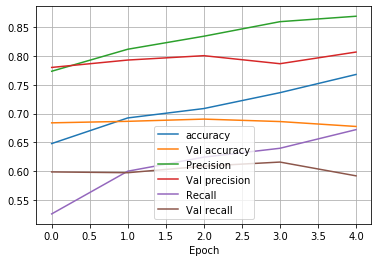

In [57]:
plt.plot(history_LSTMEmb.history["loss"], label="Loss")
plt.plot(history_LSTMEmb.history["val_loss"], label="Val loss")
plt.title("Loss")
plt.xlabel("Epoch")    
plt.legend()
plt.grid()
plt.show()
plt.plot(history_LSTMEmb.history["accuracy"], label="accuracy")
plt.plot(history_LSTMEmb.history["val_accuracy"], label="Val accuracy")
plt.plot(history_LSTMEmb.history["precision_2"], label="Precision")
plt.plot(history_LSTMEmb.history["val_precision_2"], label="Val precision")
plt.plot(history_LSTMEmb.history["recall_2"], label="Recall")
plt.plot(history_LSTMEmb.history["val_recall_2"], label="Val recall")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

In [24]:
def make_LSTM2DenseAlt(embedding = embedding, load = False, model = ""):
    m = Sequential()    
    #Embedding
    m.add(embedding.get_keras_embedding(True)) 

    m.add(LSTM(256, return_sequences=False))

    m.add(Dense(75, activation='relu'))
    m.add(keras.layers.Dropout(0.2))
    m.add(Dense(25, activation='relu'))
    m.add(keras.layers.Dropout(0.2))
    m.add(Dense(class_size, activation='softmax'))

    #from documentation: metrics is CategoricalAccuray because of the loss function
    m.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    m.summary()
    if load:
        if model == "":
            raise ValueError("Invalid model name")
        m.load_weights(model_path+model)       
    return m

m= make_LSTM2DenseAlt()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 50)          20000000  
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_5 (Dense)              (None, 75)                19275     
_________________________________________________________________
dropout_3 (Dropout)          (None, 75)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 25)                1900      
_________________________________________________________________
dropout_4 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 5)                

In [33]:
history_LSTM2DenseAlt = train(m, t_train, y_train, t_val, y_val, epochs)
save(m, "LSTM2DenseAlt{}_emb.h5".format(epochs))

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


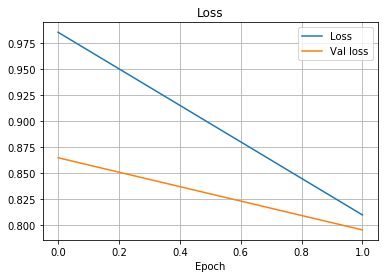

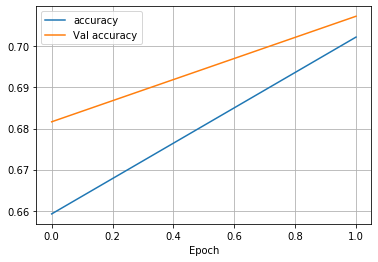

In [31]:
print(history_LSTM2DenseAlt.history.keys())
plt.plot(history_LSTM2DenseAlt.history["loss"], label="Loss")
plt.plot(history_LSTM2DenseAlt.history["val_loss"], label="Val loss")
plt.title("Loss")
plt.xlabel("Epoch")    
plt.legend()
plt.grid()
plt.show()
plt.plot(history_LSTM2DenseAlt.history["accuracy"], label="accuracy")
plt.plot(history_LSTM2DenseAlt.history["val_accuracy"], label="Val accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid()
plt.show()

In [32]:
evaluate(m, t_test, y_test)
evaluate(m, s_test, y_test)

30000/30000 [==============================] - 205s 7ms/step
Loss: 0.8087091227531433
Accuracy: 0.699566662311554
Others: []
[[5.96333333e-02 6.66666667e-04 7.70000000e-03 2.26666667e-03
  1.97333333e-02]
 [1.77000000e-02 5.66666667e-04 9.86666667e-03 5.80000000e-03
  1.74333333e-02]
 [1.06666667e-02 5.00000000e-04 1.27000000e-02 1.35333333e-02
  3.91333333e-02]
 [4.40000000e-03 1.66666667e-04 5.80000000e-03 1.33333333e-02
  1.19400000e-01]
 [1.15333333e-02 6.66666667e-05 4.20000000e-03 9.86666667e-03
  6.13333333e-01]]

              precision    recall  f1-score   support

           0       0.57      0.66      0.61      2700
           1       0.29      0.01      0.02      1541
           2       0.32      0.17      0.22      2296
           3       0.30      0.09      0.14      4293
           4       0.76      0.96      0.85     19170

    accuracy                           0.70     30000
   macro avg       0.45      0.38      0.37     30000
weighted avg       0.62      0.70      

([0.9282182530403137, 0.6527666449546814], array([0, 2, 4, ..., 0, 4, 4]))

# Comparison with a different dataset

To investigate if the heavilty depends on the context or if it can be used in a different context. Does it predict based of words that do not express a preferce?

In [34]:
steam = pd.read_csv(alt_data_path)
steam = steam[["review", "recommendation"]]
#Missing data -> empty string
steam["review"].fillna("", inplace=True)
#No label -> discard
steam.dropna()
steam["y"] = (steam["recommendation"] == "Recommended").astype(int)

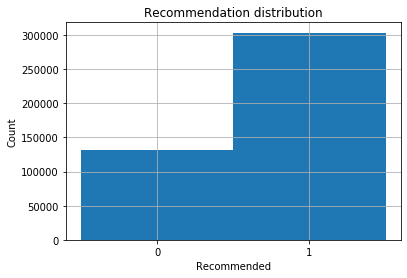

Recommendation ([No, Yes]): [131298, 303593]
Not recommended:30.19%
Recommended:69.81%


In [35]:
recommendation = plt.hist(steam["y"],bins = [-0.5, 0.5, 0.5,1.5])
plt.title("Recommendation distribution")
plt.grid()
plt.xlabel("Recommended")
plt.ylabel("Count")
plt.xticks([0,1])
plt.show()

recommendation = recommendation[0]
recommendation = [int(recommendation[i]) for i in range(len(recommendation)) if i%2==0]
print("Recommendation ([No, Yes]):", recommendation)
print("Not recommended:{:.2f}%".format(100 * recommendation[0] / (recommendation[0] + recommendation[1])))
print("Recommended:{:.2f}%".format(100 * recommendation[1] / (recommendation[0] + recommendation[1])))

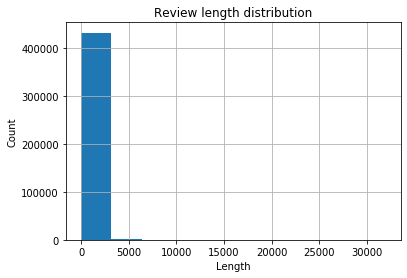

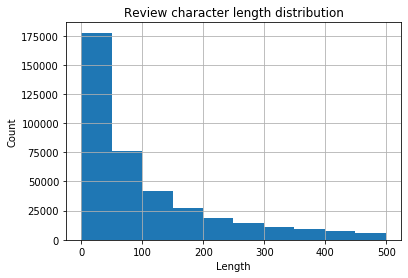

In [36]:
steam_length = [len(i) for i in steam["review"]]
plt.hist(steam_length)
plt.title("Review length distribution")
plt.grid()
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

plt.hist([i for i in steam_length if i < 500])
plt.title("Review character length distribution")
plt.grid()
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [45]:
steam_model_1 = make_LSTMDeep(load = True, model = "LSTMDeep_ep2_emb.h5")
steam_model_2 = make_LSTM2Dense(load = True, model = "LSTM2Dense2_emb.h5")

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 50)          20000000  
_________________________________________________________________
lstm_5 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_11 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_6 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)               

In [41]:
#Prediction in [1,2,3,4,5]

#Try both models
steam_model = steam_model_2
y_pred = []
batch_size = 2048
for i in range(int(np.floor(len(steam["review"]) / batch_size))+1):
    batch = get_sequences(tk, steam["review"][i*batch_size:i*batch_size+batch_size], seq_len)
    y_batch = steam_model.predict(batch)
    if len(y_batch) != 0:
        y_pred.extend(y_batch)
    print("\rBatch {} out of {}".format(i+1, int(np.floor(len(steam["review"]) / batch_size))), end="")
    

#Convert to [0, 1] = [Not recommended, Recommended]
y_pred = np.array(y_pred)#[:len(steam["y"])]
y_pred_prob = np.array([y_pred[:,0]+y_pred[:,1]+0.5*y_pred[:,2], y_pred[:,3]+y_pred[:,4]+0.5*y_pred[:,2]]).T
y_pred_rec = (np.argmax(y_pred_prob,axis = 1)).astype(int)
print("\nPredicted +:", np.sum(y_pred_rec))

Batch 213 out of 212
Predicted +: 372350


In [42]:
print(confusion_matrix(steam["y"], y_pred_rec, normalize="all"))
print()
print(classification_report(steam["y"], y_pred_rec))
print()

[[0.09783601 0.20407412]
 [0.04597244 0.65211743]]

              precision    recall  f1-score   support

           0       0.68      0.32      0.44    131298
           1       0.76      0.93      0.84    303593

    accuracy                           0.75    434891
   macro avg       0.72      0.63      0.64    434891
weighted avg       0.74      0.75      0.72    434891




## Extra

Predict the sentiment of words that express a preference

In [63]:
m1 = make_LSTMDeep(load= True, model = "LSTMDeep_ep2_emb.h5")
m2 = make_LSTM2Dense(load= True, model = "LSTM2Dense2_emb.h5")

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 50)          20000000  
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               314368    
_________________________________________________________________
dense_29 (Dense)             (None, 100)               25700     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_18 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_31 (Dense)             (None, 50)              

In [106]:
text = ["hate", "disgusting", "dislike", "don't like", "fine", "quite good", "ok", "like", "love", "perfect"]
s_text = get_sequences(tk, text, None)
pred1 = m1.predict(s_text)
pred2 = m2.predict(s_text)

In [107]:
for i in zip(text, pred1, pred2):
    #print(i)
    print(i[0], ":", np.argmax(i[1]) + 1, np.argmax(i[2]) + 1)

hate : 1 1
disgusting : 1 1
dislike : 1 1
don't like : 5 5
fine : 5 3
quite good : 5 5
ok : 1 2
like : 5 5
love : 5 5
perfect : 5 5
